In [2]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

from copy import copy

import torch
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam, pyro_method
from pyro.nn.module import to_pyro_module_
from pyro.poutine import trace, replay
from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam


from causal_pyro.query.do_messenger import do
from pyciemss.ODE.models import SVIIvR
from pyciemss.utils import run_inference

In [3]:
def plot_predictive(prediction, data, title=""):
    t = np.linspace(0, 160, 160)
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    vars = ["S_obs", "V_obs", "I_obs", "R_obs"]
    S, V, I, R = [d.detach().numpy()/1000 for d in data]

    S_low, V_low, I_low, R_low = [torch.quantile(prediction[k], 0.05, dim=0).detach().numpy()/1000 for k in vars]
    S_up, V_up, I_up, R_up = [torch.quantile(prediction[k], 0.95, dim=0).detach().numpy()/1000 for k in vars]

    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.fill_between(t, S_low, S_up, color='b', alpha=0.2)
    ax.plot(t, V, 'purple', alpha=0.5, lw=2, label='Vaccinated')
    ax.fill_between(t, V_low, V_up, color='purple', alpha=0.2)
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.fill_between(t, I_low, I_up, color='r', alpha=0.2)
    ax.plot(t, R, 'green', alpha=0.5, lw=2, label='Recovered')
    ax.fill_between(t, R_low, R_up, color='green', alpha=0.2)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title(title)
    plt.show()

In [4]:
def get_tspan(start, end, steps):
    return torch.linspace(float(start), float(end), steps)

In [5]:
# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0.0, 1.0, 0.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

initial_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I0, Iv0, R0))
tspan = get_tspan(0, 160, 160)

In [6]:
# Generate data
ode_model = SVIIvR(N)
S_obs, V_obs, I_obs, R_obs = ode_model(initial_state, tspan)

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_69356/802419981.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


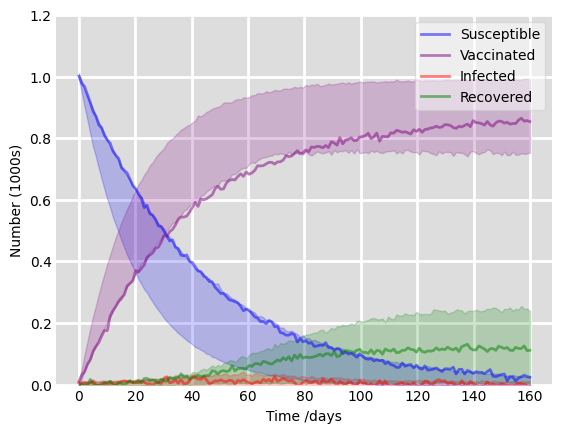

In [7]:
prior_prediction = Predictive(ode_model, num_samples=100)(initial_state, tspan)
plot_predictive(prior_prediction, (S_obs, V_obs, I_obs, R_obs))

## Apply and Visualize Interventions

In [8]:
intervention_assignment = torch.tensor([10.])

# We can apply an intervention at local moments in time, as well as globally.
# Note: interventions as lambda expressions can only occur if we're explicit about time.

controlled_model = do(ode_model, {"SV_flux %f" % (t): lambda x : x + intervention_assignment for t in tspan})
# controlled_model = do(ode_model, {"SV_flux": intervention_assignment})

S_int, V_int, I_int, R_int = controlled_model(initial_state, tspan)

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_69356/802419981.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


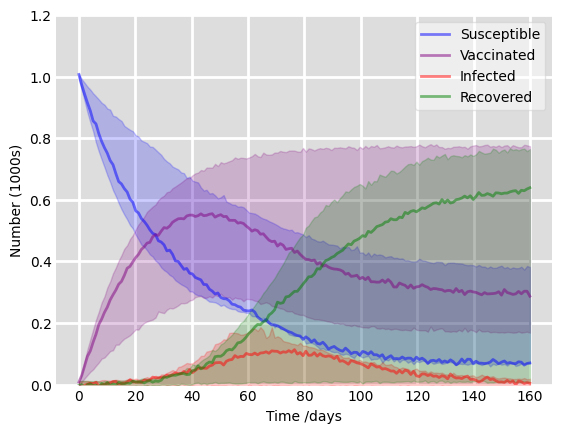

In [9]:
intervention_prediction = Predictive(controlled_model, num_samples=100)(initial_state, tspan)
plot_predictive(intervention_prediction, (S_int, V_int, I_int, R_int))

## Run Posterior Inference

In [10]:
guide = AutoNormal(ode_model)
# In this scenario we only condition on the number of infected individuals
# data = {"S_obs":None, "V_obs":None, "I_obs":I_obs, "R_obs":None}
data = {"S_obs":S_obs, "V_obs":V_obs, "I_obs":I_obs, "R_obs":R_obs}

run_inference(ode_model, guide, initial_state, tspan, data, num_iterations=100, verbose=True)

[iteration 0001] loss: 110552.9506
[iteration 0026] loss: 16307.8100
[iteration 0051] loss: 10996.1729
[iteration 0076] loss: 6928.3305


/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_69356/802419981.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


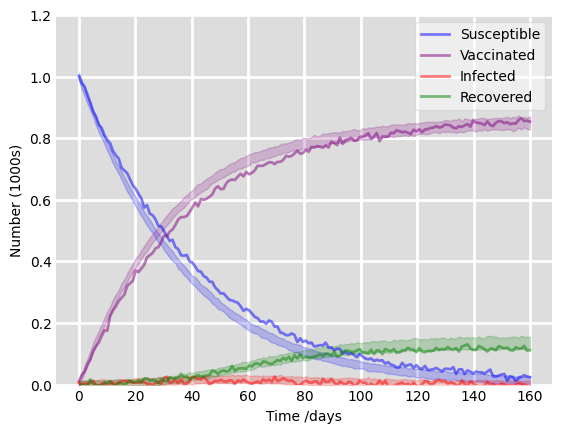

In [11]:
# Posterior predictive under our original model.
posterior_prediction = Predictive(ode_model, guide=guide, num_samples=100)(initial_state, tspan)
plot_predictive(posterior_prediction, (S_obs, V_obs, I_obs, R_obs))

/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_69356/802419981.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


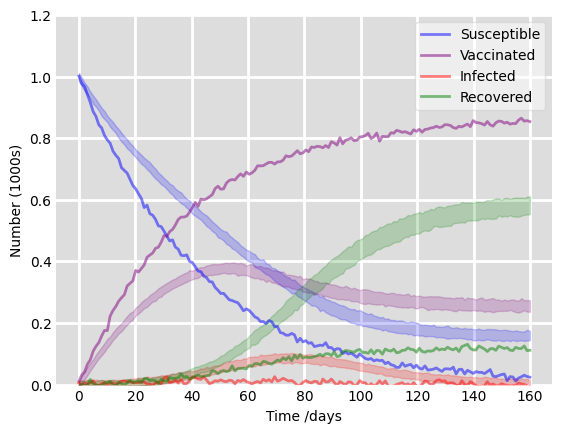

In [12]:
# Posterior predictive under our intervened model.
causal_prediction = Predictive(controlled_model, guide=guide, num_samples=100)(initial_state, tspan)
plot_predictive(causal_prediction, (S_obs, V_obs, I_obs, R_obs))
# TODO: annotate the graphic. This shows the causal posterior predictive distribution compared with the observed data trajectory. 

## Decision Making under Uncertainty

In [21]:
use_posterior = True

intervention_assignment = torch.tensor(0., requires_grad=True)
optimizer = torch.optim.Adam([intervention_assignment], lr=0.05)

controlled_model = lambda int : do(ode_model, {"SV_flux %f" % (t): lambda x : x + int for t in tspan})(initial_state, tspan)

for i in range(500):
    if use_posterior:
        # Sample from the approximate posterior and replay through the model.
        # Note: Because we're using the Pytorch optimizer that targets tensors, we don't need to freeze guide parameters.
        guide_tr = trace(guide).get_trace(initial_state, tspan)
        model_tr = trace(replay(controlled_model, trace=guide_tr)).get_trace(intervention_assignment)
    else:
        model_tr = trace(controlled_model).get_trace(intervention_assignment)

    # If this value is positive, the constraint is not satisfied.
    relaxed_constraint = torch.max(model_tr.nodes["R_obs"]['value'][-1] - torch.tensor([100.]), torch.tensor([0.]))

    # Relaxed constrained optimization (flux is negative by default, therefore we want to penalize "smaller" flux values.)
    loss = -intervention_assignment + relaxed_constraint

    optimizer.zero_grad()
    loss.backward()

    if i % 10 == 0:
        print("[iteration %04d] loss: %.4f [intervention_assignment %.4f]" % (i + 1, loss, intervention_assignment))

    optimizer.step()

[iteration 0001] loss: 43.7227 [intervention_assignment 0.0000]
[iteration 0011] loss: 41.0856 [intervention_assignment -0.4880]
[iteration 0021] loss: 25.7586 [intervention_assignment -0.9322]
[iteration 0031] loss: 19.2776 [intervention_assignment -1.3882]
[iteration 0041] loss: 8.2797 [intervention_assignment -1.7548]
[iteration 0051] loss: 1.9962 [intervention_assignment -1.9962]
[iteration 0061] loss: 2.1957 [intervention_assignment -2.1957]
[iteration 0071] loss: 6.4030 [intervention_assignment -2.3079]
[iteration 0081] loss: 2.3582 [intervention_assignment -2.3582]
[iteration 0091] loss: 2.3525 [intervention_assignment -2.3525]
[iteration 0101] loss: 2.3712 [intervention_assignment -2.3712]
[iteration 0111] loss: 6.2769 [intervention_assignment -2.4172]
[iteration 0121] loss: 2.4536 [intervention_assignment -2.4536]
[iteration 0131] loss: 2.4379 [intervention_assignment -2.4379]
[iteration 0141] loss: 2.4475 [intervention_assignment -2.4475]
[iteration 0151] loss: 2.4624 [interv